In [34]:
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

# %% [code]
# Data Loading and Cleaning
df = pd.read_csv("data.csv")
df.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [ ]:
df.dropna(inplace=True)

# Encode the Diagnosis column: assume 'M' (malignant) and 'B' (benign) → M:1, B:0
df["Diagnosis"] = LabelEncoder().fit_transform(df["Diagnosis"])

# %% [code]
# Preprocessing: Use all features and scale them
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %% [code]
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
# %% [code]
# Model Definition with Tuned Hyperparameters for XGBoost to help mitigate overfitting
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(
        random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=3
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        max_depth=3,          # Lower complexity to prevent overfitting
        learning_rate=0.05,   # Slower learning rate for more gradual updates
        gamma=1,              # Minimum loss reduction to make a split
        subsample=0.8,        # Fraction of observations to sample for each tree
        colsample_bytree=0.8, # Fraction of features to sample for each tree
        reg_alpha=0.1,        # L1 regularization term
        reg_lambda=1          # L2 regularization term
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42, max_depth=5, min_samples_split=10, min_samples_leaf=5
    ),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True)
}

# %% [code]
# Cross-Validation: Compute F1 Scores using 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring="f1")
    cv_results[name] = np.mean(scores)
    
print("Cross-Validated F1 Scores:")
for name, score in cv_results.items():
    print(f"{name}: {score:.4f}")

Cross-Validated F1 Scores:
Logistic Regression: 0.9633
Random Forest: 0.9358
XGBoost: 0.9429
Decision Tree: 0.8886
Naive Bayes: 0.9045
SVM: 0.9666


In [36]:
# %% [code]
# Evaluate Training and Test Accuracies; Plot a Line Graph for Comparison
model_names = []
train_accuracies = []
test_accuracies = []

for name, model in models.items():
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    model_names.append(name)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"{name}: Training Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")


Logistic Regression: Training Accuracy = 0.9868, Test Accuracy = 0.9649
Random Forest: Training Accuracy = 0.9846, Test Accuracy = 0.9649
XGBoost: Training Accuracy = 0.9934, Test Accuracy = 0.9737
Decision Tree: Training Accuracy = 0.9626, Test Accuracy = 0.9035
Naive Bayes: Training Accuracy = 0.9451, Test Accuracy = 0.9211
SVM: Training Accuracy = 0.9868, Test Accuracy = 0.9737


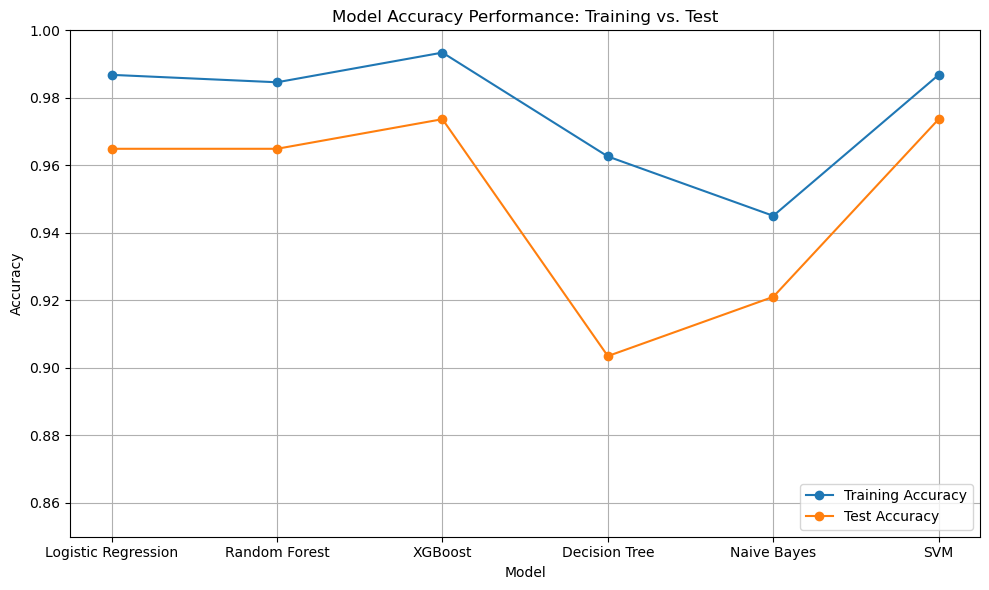

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(model_names, train_accuracies, marker="o", linestyle="-", label="Training Accuracy")
plt.plot(model_names, test_accuracies, marker="o", linestyle="-", label="Test Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Performance: Training vs. Test")
plt.ylim(0.85, 1.0)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


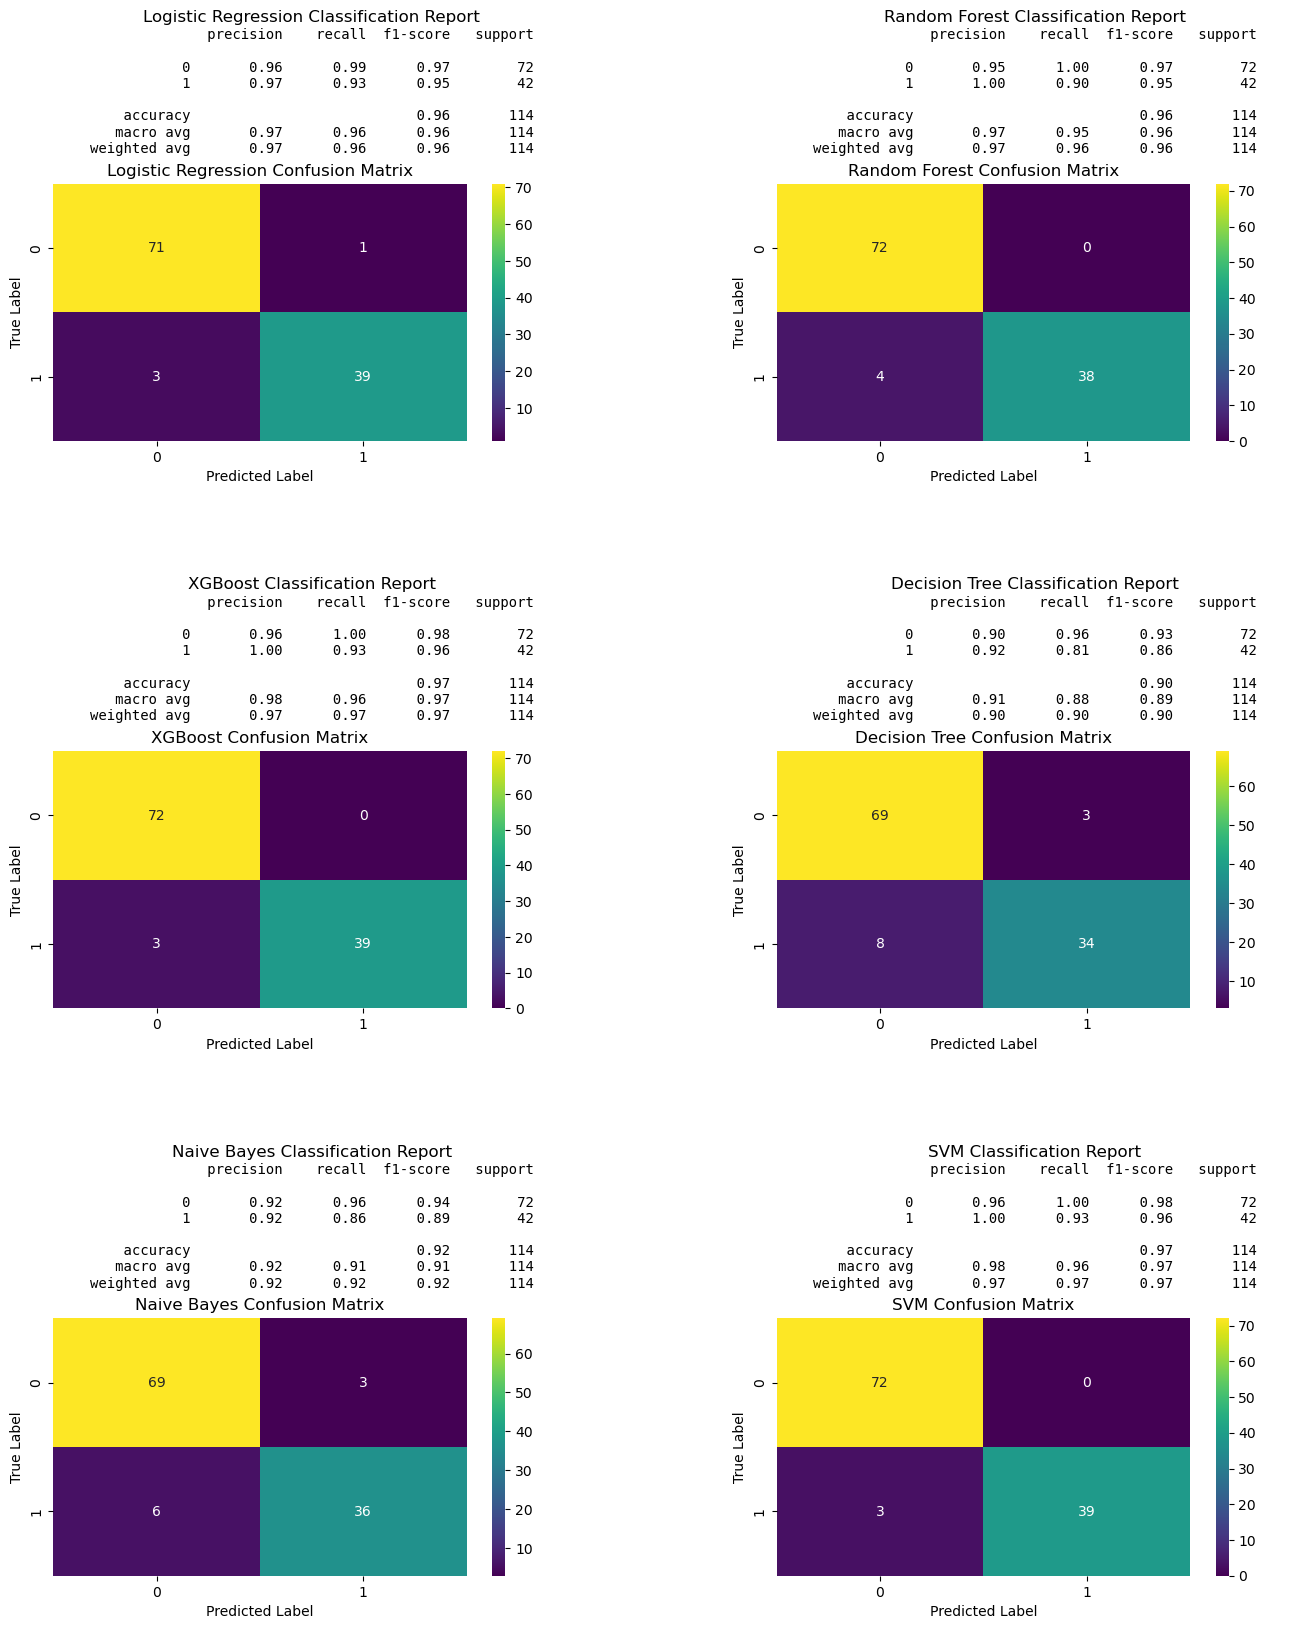

In [43]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Create a figure with an outer GridSpec of 3 rows x 2 columns (one cell per model)
fig = plt.figure(figsize=(16, 20))
outer = gridspec.GridSpec(3, 2, wspace=0.4, hspace=0.4)

# Loop through the models; assume 'models', 'X_train', 'X_test', 'y_train', and 'y_test' are defined
for i, (name, model) in enumerate(models.items()):
    # Create an inner grid for each model: 2 rows (top for classification report, bottom for confusion matrix)
    inner = gridspec.GridSpecFromSubplotSpec(
        2, 1,
        subplot_spec=outer[i],
        height_ratios=[1, 2],
        hspace=0.1
    )
    # Top subplot: Classification Report (as text)
    ax_text = plt.Subplot(fig, inner[0])
    ax_text.axis("off")
    fig.add_subplot(ax_text)
    
    # Bottom subplot: Confusion Matrix (heatmap)
    ax_cm = plt.Subplot(fig, inner[1])
    fig.add_subplot(ax_cm)
    
    # Train the model and generate predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Generate classification report text
    rep_str = classification_report(y_test, y_pred)
    
    # Display the classification report text in ax_text
    ax_text.text(0.5, 0.5, rep_str, fontsize=10, ha="center", va="center", family="monospace")
    ax_text.set_title(f"{name} Classification Report", fontsize=12, pad=10)
    
    # Compute the confusion matrix and plot it using seaborn heatmap in ax_cm
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax_cm)
    ax_cm.set_title(f"{name} Confusion Matrix", fontsize=12)
    ax_cm.set_xlabel("Predicted Label")
    ax_cm.set_ylabel("True Label")

plt.tight_layout()
plt.show()


Logistic Regression: Test Accuracy = 0.9649
Random Forest: Test Accuracy = 0.9649
XGBoost: Test Accuracy = 0.9737
Decision Tree: Test Accuracy = 0.9035
Naive Bayes: Test Accuracy = 0.9211
SVM: Test Accuracy = 0.9737


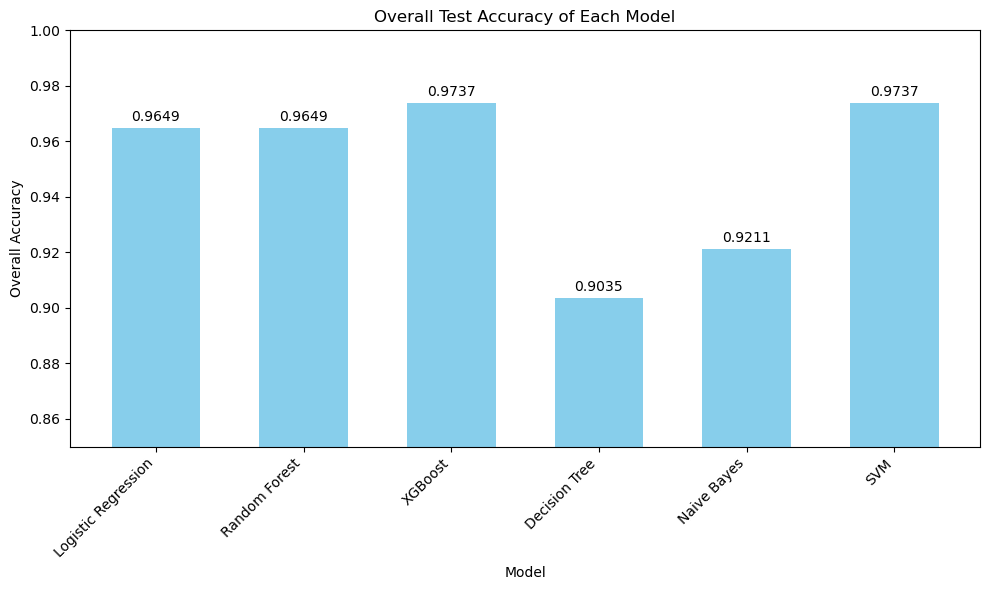

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming that X_train, X_test, y_train, y_test, and models are already defined
model_names = []
overall_accuracies = []

# Train each model and compute the test accuracy
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_names.append(name)
    overall_accuracies.append(acc)
    print(f"{name}: Test Accuracy = {acc:.4f}")

# Set up the positions for each bar
x = np.arange(len(model_names))
width = 0.6

plt.figure(figsize=(10, 6))
bars = plt.bar(x, overall_accuracies, width, color='skyblue')

plt.xlabel("Model")
plt.ylabel("Overall Accuracy")
plt.title("Overall Test Accuracy of Each Model")
plt.xticks(x, model_names, rotation=45, ha="right")
plt.ylim(0.85, 1.0)

# Annotate each bar with its accuracy value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()
